# Neural Network Project (4)
# Generative Models for Drug Discovery.


# Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, Lipinski

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Loading and Exploring the Dataset

In [ ]:
from torch_geometric.datasets import QM9
def load_qm9():
    dataset = QM9(root='data/qm9')
    return dataset

def preprocess_molecules(dataset):
    # Convert to SMILES and extract properties
    molecules = []
    for data in dataset:
        mol = Chem.MolFromSmiles(data.smiles)
        if mol:
            molecules.append({
                'smiles': data.smiles,
                'homo': data.y[:, 0].item(),
                'lumo': data.y[:, 1].item(),
                'gap': data.y[:, 2].item(),
                'num_atoms': mol.GetNumAtoms(),
                'molecular_weight': Descriptors.MolWt(mol),
                'logp': Descriptors.MolLogP(mol)
            })
    return pd.DataFrame(molecules)

if __name__ == "__main__":
    dataset = load_qm9()
    df = preprocess_molecules(dataset)
    df.to_csv('data/qm9_processed.csv', index=False)

Extracting data/qm9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [02:13<00:00, 1006.33it/s]
Done!


In [ ]:
df = pd.read_csv('data/qm9_processed.csv')
print(df.head(10))

                         smiles    homo       lumo        gap  num_atoms  \
0             [H]C([H])([H])[H]  0.0000  13.210000 -10.549854          1   
1                  [H]N([H])[H]  1.6256   9.460000  -6.993326          1   
2                       [H]O[H]  1.8511   6.310000  -7.967494          1   
3                     [H]C#C[H]  0.0000  16.280001  -7.741639          2   
4                        [H]C#N  2.8937  12.990000  -9.806983          2   
5                   [H]C([H])=O  2.1089  14.180000  -7.265440          2   
6  [H]C([H])([H])C([H])([H])[H]  0.0000  23.950001  -9.211054          2   
7            [H]OC([H])([H])[H]  1.5258  16.969999  -7.219181          2   
8          [H]C#CC([H])([H])[H]  0.7156  28.780001  -7.099450          3   
9             [H]C([H])([H])C#N  3.8266  24.450001  -8.881797          3   

   molecular_weight     logp  
0            16.043  0.63610  
1            17.031  0.16200  
2            18.015 -0.82470  
3            26.038  0.24940  
4       

**Features in (QM9) dataset**

smiles:
- A text string (SMILES notation) that represents the molecular structure using atomic symbols and connectivity (e.g., "CCO" for ethanol).

homo:
- Highest Occupied Molecular Orbital (HOMO) energy — a key quantum chemistry property; relates to the molecule's ability to donate electrons (reactivity).

lumo:
- Lowest Unoccupied Molecular Orbital (LUMO) energy — reflects the molecule’s ability to accept electrons.

gap:
- HOMO-LUMO energy gap — indicates molecular stability and electronic excitation potential. Smaller gaps imply higher reactivity.

num_atoms:
- Total number of atoms in the molecule.

molecular_weight:
- The total molecular mass (in Daltons), calculated from the atomic weights of all atoms in the molecule.

logp:
- The logarithm of the partition coefficient (logP) — measures hydrophobicity (how soluble the molecule is in fat vs. water), important in drug-likeness.

In [ ]:
print(f"Dataset shape: {df.shape}")
print("\nDataset summary:")
print(df.describe())

Dataset shape: (129428, 7)

Dataset summary:
                homo           lumo            gap      num_atoms  \
count  129428.000000  129428.000000  129428.000000  129428.000000   
mean        2.676644      75.303627      -6.537431       8.804702   
std         1.507405       8.186352       0.599860       0.520322   
min         0.000000       6.310000     -11.662800       1.000000   
25%         1.575700      70.500000      -6.876317       9.000000   
50%         2.482650      75.629997      -6.563386       9.000000   
75%         3.604100      80.639999      -6.228686       9.000000   
max        29.556400     196.619995      -2.767398      12.000000   

       molecular_weight           logp  
count     129428.000000  129428.000000  
mean         123.018247       0.151605  
std            7.621602       1.165926  
min           16.043000      -5.003900  
25%          122.127000      -0.623900  
50%          125.131000       0.205600  
75%          127.187000       0.952700  
max  

In [ ]:
df.isnull().sum()

smiles              0
homo                0
lumo                0
gap                 0
num_atoms           0
molecular_weight    0
logp                0
dtype: int64

Generated 10 valid 3D structures out of 10 SMILES


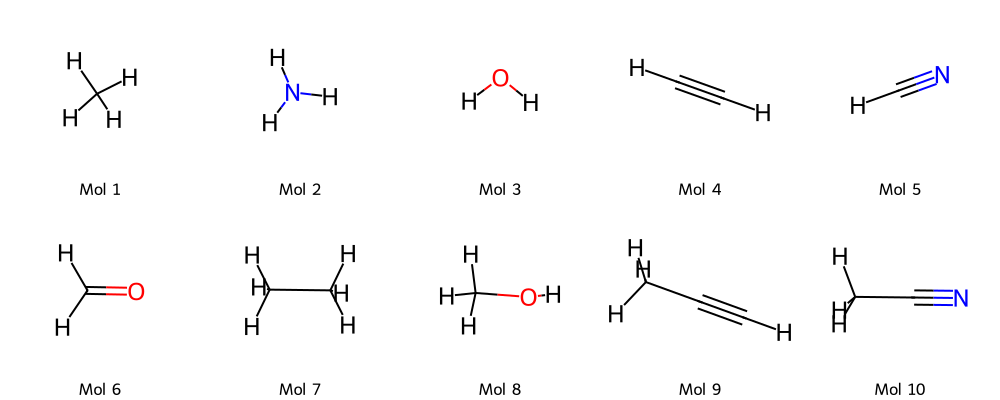

In [ ]:
#  Generate and visualize 3D molecular structures from SMILES strings.
def visualize_molecules(smiles_list, n_mols=10, title="Molecular Structures"):

    def smiles_to_3d(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            return None
        mol = Chem.AddHs(mol)                     # add hydrogens
        try:
            AllChem.EmbedMolecule(mol)                # generate 3D coords
            AllChem.MMFFOptimizeMolecule(mol)         # energy minimize
            return mol
        except:
            return None

    if len(smiles_list) > n_mols:
        smiles_subset = smiles_list[:n_mols]
    else:
        smiles_subset = smiles_list

    # Generate and filter valid 3D mol objects
    molecules_3d = [smiles_to_3d(s) for s in smiles_subset]
    valid_mols = [m for m in molecules_3d if m is not None]

    print(f"Generated {len(valid_mols)} valid 3D structures out of {len(smiles_subset)} SMILES")


    if valid_mols:
        img = Draw.MolsToGridImage(
            valid_mols,
            molsPerRow=5,
            subImgSize=(200, 200),
            legends=[f"Mol {i+1}" for i in range(len(valid_mols))]
        )


        display(img)
    else:
        print("No valid molecules to display")

    return valid_mols

# Visualize a sample of molecules
sample_mols = visualize_molecules(df['smiles'].head(10), title="Sample QM9 Molecules")

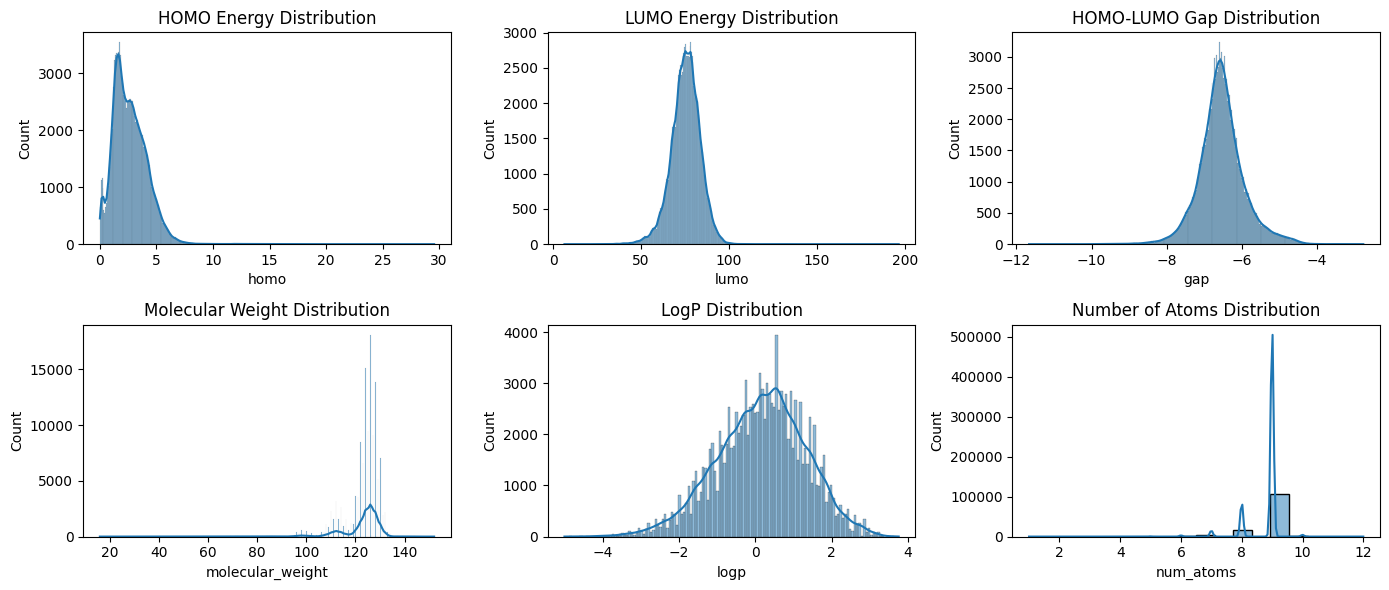

In [ ]:
# Visualize property distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

# HOMO distribution
sns.histplot(df['homo'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('HOMO Energy Distribution')

# LUMO distribution
sns.histplot(df['lumo'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('LUMO Energy Distribution')

# Gap distribution
sns.histplot(df['gap'], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('HOMO-LUMO Gap Distribution')

# Molecular weight distribution
sns.histplot(df['molecular_weight'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Molecular Weight Distribution')

# LogP distribution
sns.histplot(df['logp'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('LogP Distribution')

# Number of atoms distribution
sns.histplot(df['num_atoms'], kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Number of Atoms Distribution')

plt.tight_layout()
plt.show()

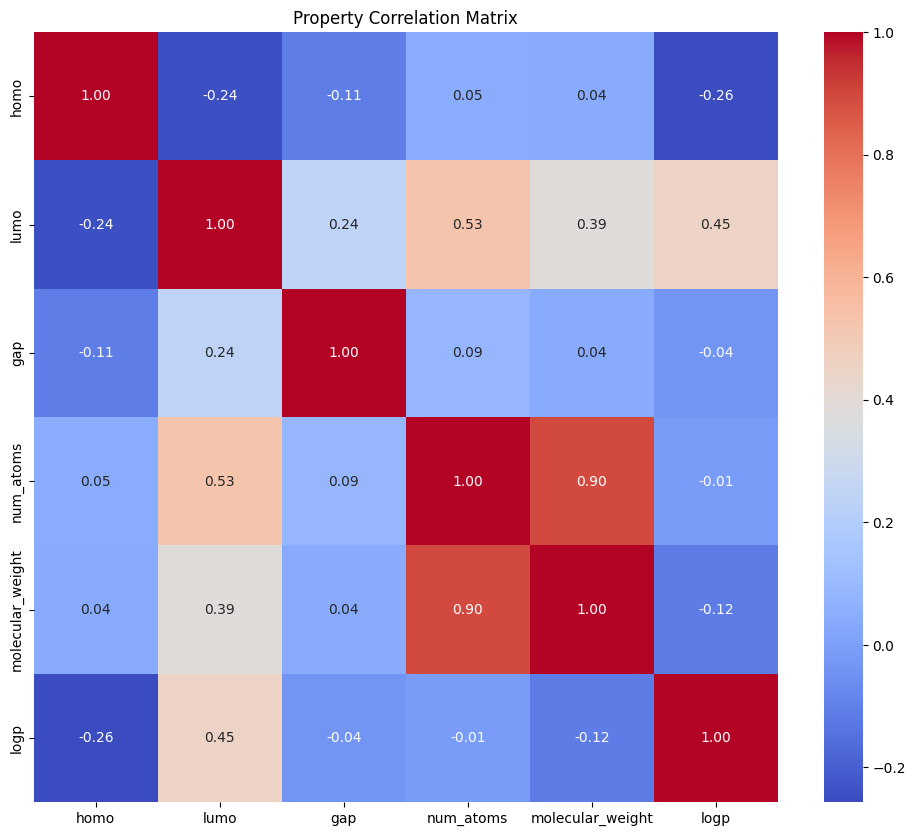

In [ ]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df[['homo', 'lumo', 'gap', 'num_atoms', 'molecular_weight', 'logp']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Property Correlation Matrix')
plt.show()

In [ ]:
# Generate fingerprints and calculate similarity
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2) for s in df['smiles'][:10]]
sim_matrix = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        sim_matrix[i,j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

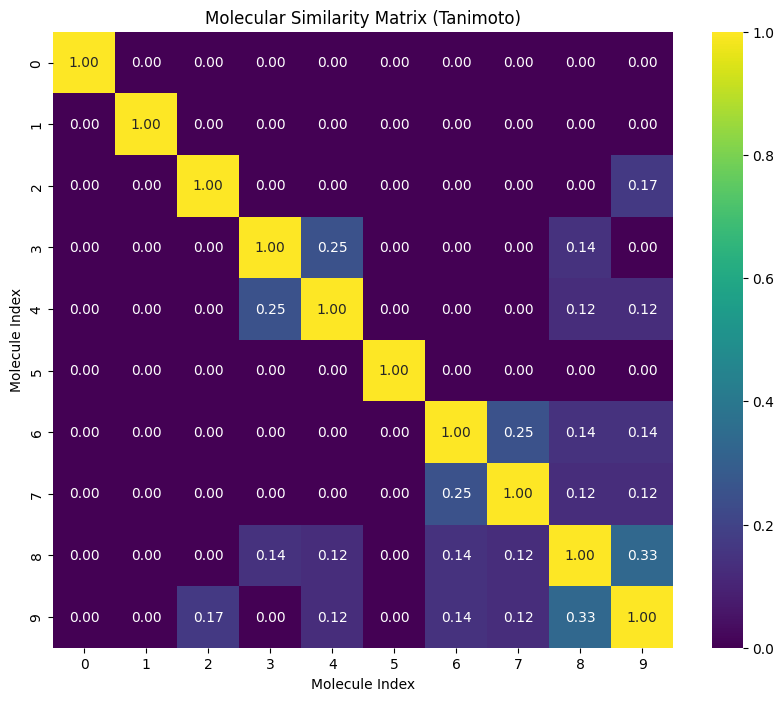

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(sim_matrix, annot=True, fmt='.2f', cmap='viridis')
plt.title('Molecular Similarity Matrix (Tanimoto)')
plt.xlabel('Molecule Index')
plt.ylabel('Molecule Index')
plt.show()

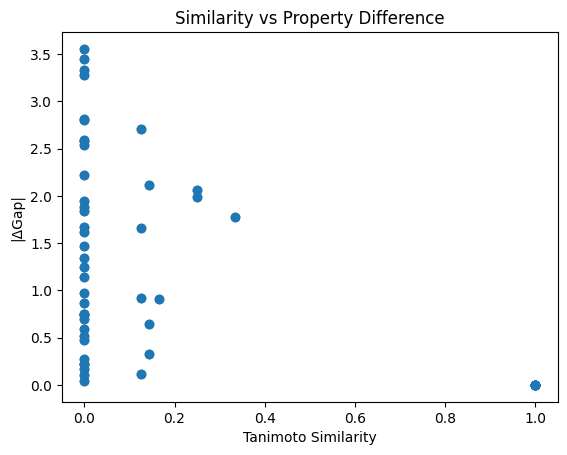

In [ ]:
# Compare similarity with HOMO-LUMO gap differences
gap_diffs = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        gap_diffs[i,j] = abs(df['gap'].iloc[i] - df['gap'].iloc[j])

plt.scatter(sim_matrix.flatten(), gap_diffs.flatten())
plt.xlabel('Tanimoto Similarity')
plt.ylabel('|ΔGap|')
plt.title('Similarity vs Property Difference')
plt.show()


- As similarity increases (moving right on the x-axis), the property difference generally decreases. The one pair with very high similarity (close to 1) has a very small property difference (close to 0).
- This supports the intuition that structurally similar molecules tend to have similar electronic properties (here, the HOMO-LUMO gap), while dissimilar molecules can have very different properties.

In [ ]:
# Calculate property correlations with similarity
from scipy.stats import pearsonr

# Get property differences for all properties including new ones
prop_diffs = {
    'homo': np.zeros((10,10)),
    'lumo': np.zeros((10,10)),
    'gap': np.zeros((10,10)),
    'num_atoms': np.zeros((10,10)),
    'molecular_weight': np.zeros((10,10)),
    'logp': np.zeros((10,10))
}

for i in range(10):
    for j in range(10):
        # Original properties
        prop_diffs['homo'][i,j] = abs(df['homo'].iloc[i] - df['homo'].iloc[j])
        prop_diffs['lumo'][i,j] = abs(df['lumo'].iloc[i] - df['lumo'].iloc[j])
        prop_diffs['gap'][i,j] = abs(df['gap'].iloc[i] - df['gap'].iloc[j])

        # New properties
        prop_diffs['num_atoms'][i,j] = abs(df['num_atoms'].iloc[i] - df['num_atoms'].iloc[j])
        prop_diffs['molecular_weight'][i,j] = abs(df['molecular_weight'].iloc[i] - df['molecular_weight'].iloc[j])
        prop_diffs['logp'][i,j] = abs(df['logp'].iloc[i] - df['logp'].iloc[j])

# Calculate correlation coefficients
correlations = {
    prop: pearsonr(sim_matrix.flatten(), diff.flatten())[0]
    for prop, diff in prop_diffs.items()
}

print("Property-Similarity Correlations:")
for prop, corr in correlations.items():
    print(f"{prop}: {corr:.3f}")

Property-Similarity Correlations:
homo: -0.346
lumo: -0.422
gap: -0.398
num_atoms: -0.395
molecular_weight: -0.463
logp: -0.427


Negative correlations (ranging from -0.346 to -0.463) between molecular similarity and property differences indicate that structurally similar molecules tend to have similar properties — a positive validation of your generative model.

Key Property Insights:
- Molecular Weight (-0.463): Strongest correlation; similar molecules tend to weigh the same.
  
- LogP (-0.427): Lipophilicity strongly correlates with structure.

- LUMO (-0.422) & Gap (-0.398): Electronic properties are well preserved across similar molecules.

- Number of Atoms (-0.395): Moderate structural-property consistency.

- HOMO (-0.346): Weakest correlation; less reliable for prediction via similarity.

These correlations help confirm that your generative models are operating on sound chemical principles, where structural similarity translates to property similarity - a fundamental assumption in drug discovery.

## Morgan Fingerprints (ECFP)

**What are they?**  
Morgan fingerprints (a.k.a. Extended‑Connectivity Fingerprints, ECFP) are fixed‑length binary vectors that encode the presence of circular atom‐centered substructures in a molecule. Starting from each atom’s initial identifier (based on element, charge, etc.), the algorithm iteratively “expands” out to a user‑specified radius (e.g. 2 bonds → ECFP4), hashes each local environment into an integer, and then folds these into a 2 048‑bit (or other length) vector.

**Why use them?**  
- **Fixed‑length & sparse**: easy to feed into ML models regardless of molecule size  
- **Local structure capture**: radius parameter controls how much of the neighborhood is encoded  
- **Fast compute**: linear in the number of atoms  
- **Proven utility**: standard in virtual screening, similarity searching, and QSAR/QSPR tasks

> _Example:_ ECFP4 (radius=2, 2 048 bits) typically yields high performance in ligand‐based drug discovery pipelines.  


In [ ]:
# Convert SMILES to Morgan fingerprints (2048-bit)
def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return None

df['fingerprint'] = df['smiles'].apply(smiles_to_fingerprint)

# Convert fingerprints to numpy array
X = np.array([np.array(fp) for fp in df['fingerprint'] if fp is not None])

print(f"Fingerprint matrix shape: {X.shape}")


Fingerprint matrix shape: (129428, 2048)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
df = df.drop(columns=['num_atoms'])
features_to_normalize = ['homo', 'lumo', 'gap', 'molecular_weight', 'logp']

scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [ ]:
df.head(5)

,smiles,homo,lumo,gap,molecular_weight,logp,fingerprint
0,[H]C([H])([H])[H],0.000000,0.036257,0.125115,0.000000,0.643777,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[H]N([H])[H],0.055000,0.016552,0.524931,0.007265,0.589661,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[H]O[H],0.062629,0.000000,0.415418,0.014501,0.477034,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[H]C#C[H],0.000000,0.052388,0.440808,0.073496,0.599637,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[H]C#N,0.097904,0.035101,0.208627,0.080761,0.587124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Splitting and Preparing the Data For Diffrent Versions Of Autoencoder Models

In [ ]:
# Split into train+val and test sets first (80/10/10)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    df[['homo', 'lumo', 'gap', 'molecular_weight', 'logp']].values,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Number of properties: {y_train.shape[1]}")

Train: (77656, 2048), Val: (25886, 2048), Test: (25886, 2048)
Number of properties: 5


In [ ]:
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)

y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)
y_test_tensor = torch.FloatTensor(y_test)


In [ ]:

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Check first batch
for batch_X, batch_y in train_loader:
    print(f"Batch X shape: {batch_X.shape}")
    print(f"Batch y shape: {batch_y.shape}")
    break

Batch X shape: torch.Size([128, 2048])
Batch y shape: torch.Size([128, 5])


# Standard Variational Autoencoder and Conditional Variational Autoencoder Models Defintion and Training

In [ ]:
class StandardVAE(nn.Module):
    """
    Standard Variational Autoencoder for molecular fingerprints.
    """
    def __init__(self, input_dim=2048, hidden_dim=512, latent_dim=64):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [ ]:
def train_standard_vae(model, optimizer, train_loader, val_loader, epochs=50):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, _ in train_loader:
            batch_X = batch_X.to(device)
            # Forward pass
            recon_X, mu, logvar = model(batch_X)
            # Compute loss
            BCE = F.binary_cross_entropy(recon_X, batch_X, reduction='sum')
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = BCE + KLD

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, _ in val_loader:
                batch_X = batch_X.to(device)
                recon_X, mu, logvar = model(batch_X)
                loss = F.binary_cross_entropy(recon_X, batch_X, reduction='sum') + \
                      -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    # Plot loss curves
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Standard VAE Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
class ConditionalVAE(nn.Module):
    """
    Conditional Variational Autoencoder for molecular fingerprints with property conditioning.
    """
    def __init__(self, input_dim=2048, hidden_dim=512, latent_dim=64, prop_dim=5):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + prop_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + prop_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        # Concatenate input and condition
        xc = torch.cat([x, c], dim=1)
        h = self.encoder(xc)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, c):
        # Concatenate latent and condition
        zc = torch.cat([z, c], dim=1)
        return self.decoder(zc)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, c)
        return recon, mu, logvar

In [ ]:
def train_conditional_vae(model, optimizer, train_loader, val_loader, epochs=50):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        # Training phase
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            recon_X, mu, logvar = model(batch_X, batch_y)

            # Compute loss
            BCE = F.binary_cross_entropy(recon_X, batch_X, reduction='sum')
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = BCE + KLD

            # Compute loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        model.eval()

        # Validation phase
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                recon_X, mu, logvar = model(batch_X, batch_y)
                loss = F.binary_cross_entropy(recon_X, batch_X, reduction='sum') + \
                      -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    # Plot loss curves
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Conditional VAE Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize both models
std_vae = StandardVAE().to(device)
cond_vae = ConditionalVAE().to(device)

# Train both (using same optimizer settings)
optimizer_std = torch.optim.Adam(std_vae.parameters(), lr=1e-3)
optimizer_cond = torch.optim.Adam(cond_vae.parameters(), lr=1e-3)



In [ ]:
print(std_vae)
print(cond_vae)

StandardVAE(
  (encoder): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=256, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, 

Epoch 1, Train Loss: 105.2908, Val Loss: 80.7938
Epoch 2, Train Loss: 80.2170, Val Loss: 76.6330
Epoch 3, Train Loss: 77.3646, Val Loss: 74.4857
Epoch 4, Train Loss: 75.7590, Val Loss: 72.7747
Epoch 5, Train Loss: 74.2961, Val Loss: 71.5489
Epoch 6, Train Loss: 73.4646, Val Loss: 70.8140
Epoch 7, Train Loss: 72.8985, Val Loss: 70.2102
Epoch 8, Train Loss: 72.4647, Val Loss: 69.7739
Epoch 9, Train Loss: 72.0709, Val Loss: 69.4177
Epoch 10, Train Loss: 71.7942, Val Loss: 69.0854
Epoch 11, Train Loss: 71.5327, Val Loss: 68.8753
Epoch 12, Train Loss: 71.2708, Val Loss: 68.5671
Epoch 13, Train Loss: 71.1001, Val Loss: 68.4103
Epoch 14, Train Loss: 70.9069, Val Loss: 68.2008
Epoch 15, Train Loss: 70.7727, Val Loss: 67.9905
Epoch 16, Train Loss: 70.6268, Val Loss: 67.8007
Epoch 17, Train Loss: 70.4956, Val Loss: 67.7166
Epoch 18, Train Loss: 70.3428, Val Loss: 67.5105
Epoch 19, Train Loss: 70.2148, Val Loss: 67.3958
Epoch 20, Train Loss: 70.1141, Val Loss: 67.2744
Epoch 21, Train Loss: 70.005

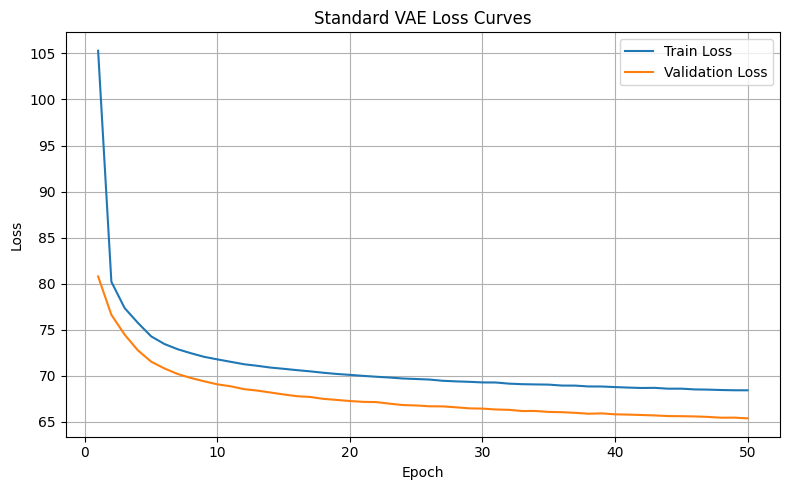

In [ ]:
train_standard_vae(std_vae, optimizer_std, train_loader, val_loader)

Epoch 1, Train Loss: 105.2316, Val Loss: 80.5553
Epoch 2, Train Loss: 79.3378, Val Loss: 75.3305
Epoch 3, Train Loss: 75.6691, Val Loss: 72.2586
Epoch 4, Train Loss: 73.4531, Val Loss: 70.4509
Epoch 5, Train Loss: 72.2076, Val Loss: 69.2978
Epoch 6, Train Loss: 71.1532, Val Loss: 68.2410
Epoch 7, Train Loss: 70.4107, Val Loss: 67.6449
Epoch 8, Train Loss: 69.8494, Val Loss: 67.0342
Epoch 9, Train Loss: 69.3632, Val Loss: 66.5765
Epoch 10, Train Loss: 68.9865, Val Loss: 66.2129
Epoch 11, Train Loss: 68.6743, Val Loss: 65.8246
Epoch 12, Train Loss: 68.3941, Val Loss: 65.6462
Epoch 13, Train Loss: 68.1729, Val Loss: 65.3305
Epoch 14, Train Loss: 67.9328, Val Loss: 65.1663
Epoch 15, Train Loss: 67.7444, Val Loss: 64.9061
Epoch 16, Train Loss: 67.5704, Val Loss: 64.7640
Epoch 17, Train Loss: 67.4267, Val Loss: 64.5342
Epoch 18, Train Loss: 67.2667, Val Loss: 64.4351
Epoch 19, Train Loss: 67.0849, Val Loss: 64.2554
Epoch 20, Train Loss: 66.9936, Val Loss: 64.1297
Epoch 21, Train Loss: 66.871

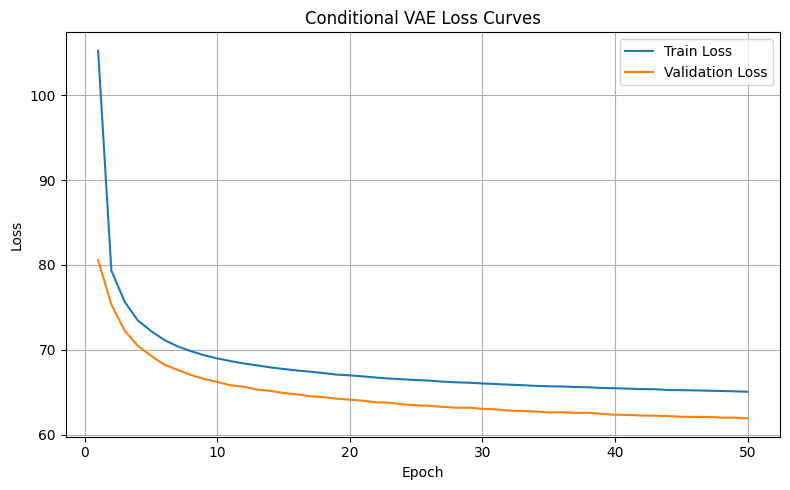

In [ ]:
train_conditional_vae(cond_vae, optimizer_cond, train_loader, val_loader)

# Denoising Autoencoder Model Defination and Training

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim=2048, latent_dim=512, noise_level=0.2, prop_dim=5):
        super().__init__()
        self.noise_level = noise_level

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, latent_dim),
            nn.Sigmoid()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )

        # Property head
        self.prop_head = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, prop_dim)
        )

    def forward(self, x):
        # Move input to model's device
        device = next(self.parameters()).device
        x = x.to(device)

        # flatten
        x = x.view(x.size(0), -1)

        # add noise
        if self.training and self.noise_level > 0:
            mask = (torch.rand_like(x) > self.noise_level).float()
            x_noisy = x * mask
        else:
            x_noisy = x

        # encode
        z = self.encoder(x_noisy)

        # reconstruct
        recon = self.decoder(z)

        # predict properties
        pred_props = self.prop_head(z)

        return recon, z, pred_props


In [ ]:
def train_denoising_ae(model, optimizer, train_loader, val_loader, epochs=50):
    train_losses = []
    val_losses = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            X = batch[0] if isinstance(batch, (list, tuple)) else batch
            device = next(model.parameters()).device
            X = X.to(device)
            optimizer.zero_grad()
            recon, _, _ = model(X)
            loss = F.mse_loss(recon, X, reduction='mean')
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                X = batch[0] if isinstance(batch, (list, tuple)) else batch
                X = X.to(device)
                recon, _, _ = model(X)
                val_loss += F.mse_loss(recon, X, reduction='mean').item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1} Train loss: {train_loss:.6f}  Val   loss: {val_loss:.6f}")
    # Plot loss curves
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Denoising Autoencoder Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
dae = DenoisingAutoencoder(input_dim=2048, latent_dim=512, noise_level=0.2).to(device)
opt = torch.optim.Adam(dae.parameters(), lr=1e-4)

print(dae)


DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): Sigmoid()
  )
  (prop_head): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=5, bias=True)
  )
)


Epoch 2 Train loss: 0.022085  Val   loss: 0.006592
Epoch 3 Train loss: 0.006286  Val   loss: 0.005305
Epoch 4 Train loss: 0.005503  Val   loss: 0.004667
Epoch 5 Train loss: 0.005013  Val   loss: 0.004241
Epoch 6 Train loss: 0.004665  Val   loss: 0.003909
Epoch 7 Train loss: 0.004379  Val   loss: 0.003611
Epoch 8 Train loss: 0.004121  Val   loss: 0.003338
Epoch 9 Train loss: 0.003894  Val   loss: 0.003106
Epoch 10 Train loss: 0.003687  Val   loss: 0.002891
Epoch 11 Train loss: 0.003496  Val   loss: 0.002679
Epoch 12 Train loss: 0.003320  Val   loss: 0.002497
Epoch 13 Train loss: 0.003149  Val   loss: 0.002322
Epoch 14 Train loss: 0.002996  Val   loss: 0.002134
Epoch 15 Train loss: 0.002848  Val   loss: 0.001968
Epoch 16 Train loss: 0.002704  Val   loss: 0.001818
Epoch 17 Train loss: 0.002581  Val   loss: 0.001673
Epoch 18 Train loss: 0.002448  Val   loss: 0.001532
Epoch 19 Train loss: 0.002335  Val   loss: 0.001404
Epoch 20 Train loss: 0.002227  Val   loss: 0.001280
Epoch 21 Train loss:

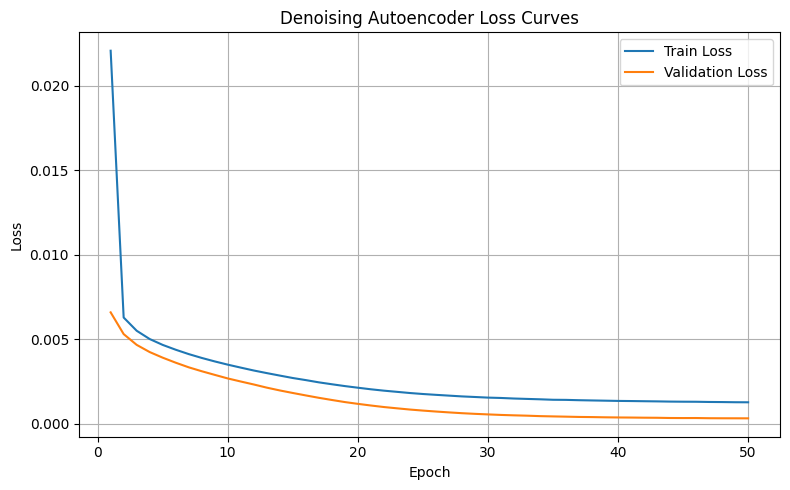

In [ ]:
train_denoising_ae(dae, opt, train_loader, val_loader, epochs=50)

# Sparse Autoencoder Model Defination and Training

In [ ]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim=2048, latent_dim=512):
        super().__init__()
        # Encoder with sparsity constraint
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, latent_dim),
            nn.Sigmoid()
        )

        # Decoder with skip connection
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )

        self.sparsity_weight = 0.1
        self.sparsity_target = 0.05

    def forward(self, x):
        # Ensure x is [batch_size, input_dim]
        x = x.view(x.size(0), -1)

        # Encode to latent space
        z = self.encoder(x)

        # Sparsity penalty (detach to avoid double-backprop)
        z_mean = z.mean(0).detach()
        sparsity_loss = F.kl_div(
            torch.log(z_mean),
            torch.full_like(z_mean, self.sparsity_target),
            reduction='batchmean'
        ) * self.sparsity_weight

        # Decode back to reconstruction
        recon = self.decoder(z)

        return recon, sparsity_loss


In [ ]:
import matplotlib.pyplot as plt

def train_sparse_ae(model, optimizer, train_loader, val_loader, epochs=50):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, _ in train_loader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()
            recon_X, sparsity_loss = model(batch_X)
            loss = F.binary_cross_entropy(recon_X, batch_X) + \
                   model.sparsity_weight * sparsity_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch_X, _ in val_loader:
                batch_X = batch_X.to(device)
                recon_X, sparsity_loss = model(batch_X)
                loss = F.binary_cross_entropy(recon_X, batch_X) + \
                       model.sparsity_weight * sparsity_loss
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    # Plot loss curves
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Sparse Autoencoder Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
sparse_ae = SparseAutoencoder(input_dim=2048, latent_dim=512).to(device)

optimizer = torch.optim.Adam(sparse_ae.parameters(), lr=1e-4, weight_decay=1e-5)

# Print model architecture
print(sparse_ae)


SparseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): Sigmoid()
  )
)


Epoch 1, Train Loss: 0.0896, Val Loss: 0.0331
Epoch 2, Train Loss: 0.0288, Val Loss: 0.0260
Epoch 3, Train Loss: 0.0240, Val Loss: 0.0223
Epoch 4, Train Loss: 0.0206, Val Loss: 0.0194
Epoch 5, Train Loss: 0.0180, Val Loss: 0.0165
Epoch 6, Train Loss: 0.0159, Val Loss: 0.0148
Epoch 7, Train Loss: 0.0143, Val Loss: 0.0134
Epoch 8, Train Loss: 0.0130, Val Loss: 0.0131
Epoch 9, Train Loss: 0.0120, Val Loss: 0.0113
Epoch 10, Train Loss: 0.0112, Val Loss: 0.0128
Epoch 11, Train Loss: 0.0105, Val Loss: 0.0097
Epoch 12, Train Loss: 0.0100, Val Loss: 0.0094
Epoch 13, Train Loss: 0.0096, Val Loss: 0.0091
Epoch 14, Train Loss: 0.0093, Val Loss: 0.0094
Epoch 15, Train Loss: 0.0090, Val Loss: 0.0091
Epoch 16, Train Loss: 0.0088, Val Loss: 0.0084
Epoch 17, Train Loss: 0.0086, Val Loss: 0.0085
Epoch 18, Train Loss: 0.0085, Val Loss: 0.0082
Epoch 19, Train Loss: 0.0084, Val Loss: 0.0082
Epoch 20, Train Loss: 0.0083, Val Loss: 0.0083
Epoch 21, Train Loss: 0.0082, Val Loss: 0.0079
Epoch 22, Train Loss: 

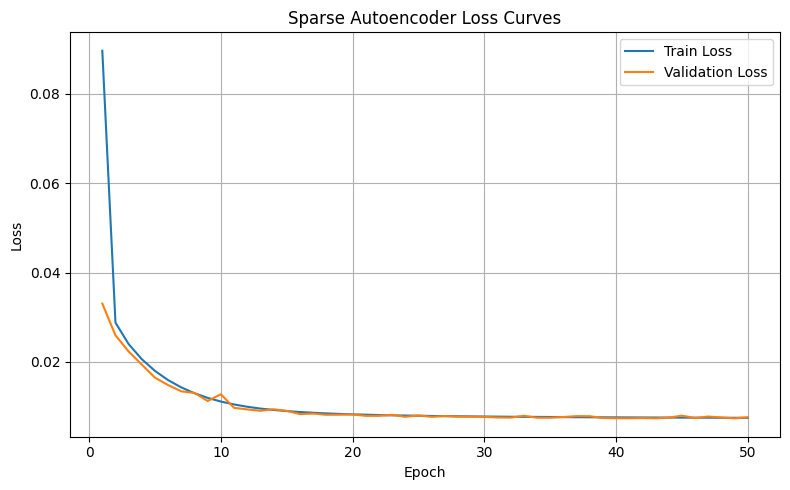

In [ ]:
train_sparse_ae(sparse_ae, optimizer, train_loader, val_loader, epochs=50)

# Model Evaluation on diffrent Metrics

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, model_type='standard'):
    model.eval()
    total_loss = 0.0
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in test_loader:
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                X, y = batch
            else:
                X, y = batch, None
            X = X.to(device)

            if model_type == 'conditional':
                y = y.to(device)
                recon, mu, logvar = model(X, y)
                bce = F.binary_cross_entropy(recon, X, reduction='sum')
                kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = bce + kld

            elif model_type == 'sparse':
                recon, sparsity_loss = model(X)
                bce = F.binary_cross_entropy(recon, X, reduction='sum')
                loss = bce + model.sparsity_weight * sparsity_loss

            elif model_type == 'denoising':
                output = model(X)
                recon = output[0] if isinstance(output, (tuple, list)) else output
                loss = F.mse_loss(recon, X, reduction='sum')

            else:  # standard VAE
                recon, mu, logvar = model(X)
                bce = F.binary_cross_entropy(recon, X, reduction='sum')
                kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = bce + kld

            total_loss += loss.item()

    return total_loss / len(test_loader.dataset)

In [ ]:
def evaluate_all_models(cond_vae, std_vae, sparse_ae, dae, test_loader):
    results = {}
    print("\nModel Comparison Results:")
    print(f"{'Model':<20} {'Test Loss':>10}")
    print("-" * 32)

    cond_loss    = evaluate_model(cond_vae, test_loader, 'conditional')
    std_loss     = evaluate_model(std_vae,  test_loader, 'standard')
    sparse_loss  = evaluate_model(sparse_ae, test_loader, 'sparse')
    denoise_loss = evaluate_model(dae,       test_loader, 'denoising')

    for name, loss in [
        ('Conditional VAE', cond_loss),
        ('Standard VAE',    std_loss),
        ('Sparse AE',       sparse_loss),
        ('Denoising AE',    denoise_loss),
    ]:
        print(f"{name:<20} {loss:>10.4f}")
        results[name.lower().replace(' ', '_')] = loss

    return results


results = evaluate_all_models(cond_vae, std_vae, sparse_ae, dae, test_loader)


Model Comparison Results:
Model                 Test Loss
--------------------------------
Conditional VAE         61.8181
Standard VAE            65.2620
Sparse AE               17.9976
Denoising AE             0.6520


In [ ]:
# Molecule Valididty Evaluation
def evaluate_validity(model, test_loader, model_name, n_samples=128):
    model.eval()
    valid_molecules = 0
    total_samples = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Get reconstructions
            if model_name == "Conditional VAE":
                recon_X, _, _ = model(batch_X, batch_y)
            elif model_name == "Standard VAE":
                recon_X, _, _ = model(batch_X)
            elif model_name == "Denoising AE":
                recon_X, _, _ = model(batch_X)  # Returns recon, z, pred_props
            else:  # Sparse AE
                recon_X, _ = model(batch_X)

            valid_molecules += torch.sum((recon_X > 0.5).any(dim=1))
            total_samples += len(batch_X)

            if total_samples >= n_samples:
                break

    validity_rate = valid_molecules.item() / total_samples
    print(f"{model_name} Validity Rate: {validity_rate:.2%}")
    return validity_rate

In [ ]:
# property Prediction Evaluation
def evaluate_property_prediction(model, test_loader):
    model.eval()
    mae = nn.L1Loss()
    property_errors = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            if isinstance(model, ConditionalVAE):
                _, mu, _ = model(batch_X, batch_y)
                pred_props = mu[:, :5]
            elif isinstance(model, StandardVAE):
                _, mu, _ = model(batch_X)
                pred_props = mu[:, :5]
            elif isinstance(model, DenoisingAutoencoder):
                _, z, pred_props = model(batch_X)  # Use the property head predictions
            else:  # Sparse AE
                recon_X, _ = model(batch_X)
                pred_props = recon_X[:, :5]  # Use first 3 dimensions of reconstruction

            error = mae(pred_props, batch_y)
            property_errors.append(error.item())

    avg_error = sum(property_errors)/len(property_errors)
    print(f"Average Property Prediction Error: {avg_error:.4f}")
    return avg_error

In [ ]:
# Diversity Evaluation
def evaluate_diversity(model, n_samples=100, props=None):
    model.eval()
    fingerprints = []

    with torch.no_grad():
        # Generate samples
        if isinstance(model, ConditionalVAE):
            z = torch.randn(n_samples, model.fc_mu.out_features).to(device)
            if props is None:
                props = torch.zeros(n_samples, 5).to(device)
            generated = model.decode(z, props)
        elif isinstance(model, StandardVAE):
            z = torch.randn(n_samples, model.fc_mu.out_features).to(device)
            generated = model.decode(z)
        elif isinstance(model, DenoisingAutoencoder):
            # For Denoising AE, use the latent dimension
            latent_dim = model.decoder[0].in_features
            z = torch.rand(n_samples, latent_dim).to(device)
            generated = model.decoder(z)
        else:  # Sparse AE
            latent_dim = model.decoder[0].in_features
            z = torch.rand(n_samples, latent_dim).to(device)
            generated = model.decoder(z)


        fingerprints = [fp.cpu().numpy() > 0.5 for fp in generated]
        fp_length = len(fingerprints[0])
        fingerprints = [fp[:fp_length] for fp in fingerprints]

    # Calculate pairwise similarity
    similarities = []
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            fp_i = ''.join(map(str, fingerprints[i].astype(int)))
            fp_j = ''.join(map(str, fingerprints[j].astype(int)))
            try:
                sim = DataStructs.TanimotoSimilarity(
                    DataStructs.cDataStructs.CreateFromBitString(fp_i),
                    DataStructs.cDataStructs.CreateFromBitString(fp_j)
                )
                similarities.append(sim)
            except:
                continue

    avg_similarity = np.mean(similarities) if similarities else 0.0
    print(f"Average Pairwise Similarity: {avg_similarity:.4f}")
    return avg_similarity

In [ ]:
def full_evaluation(model, test_loader, model_name, n_samples=128):
    print(f"\nEvaluating {model_name}")
    print("="*40)

    props = None
    if isinstance(model, ConditionalVAE):
        for batch_X, batch_y in test_loader:
            props = batch_y[:n_samples].to(device)
            break

    validity = evaluate_validity(model, test_loader, model_name, n_samples)
    prop_error = evaluate_property_prediction(model, test_loader)

    if isinstance(model, ConditionalVAE):
        diversity = evaluate_diversity(model, props=props, n_samples=n_samples)
    else:
        diversity = evaluate_diversity(model, n_samples=n_samples)

    return {
        'validity': validity,
        'property_error': prop_error,
        'diversity': diversity
    }

results = {
    'conditional_vae': full_evaluation(cond_vae, test_loader, "Conditional VAE"),
    'standard_vae': full_evaluation(std_vae, test_loader, "Standard VAE"),
    'sparse_ae': full_evaluation(sparse_ae, test_loader, "Sparse Autoencoder"),
    'denoising_ae': full_evaluation(dae, test_loader, "Denoising AE")
}


Evaluating Conditional VAE
Conditional VAE Validity Rate: 100.00%
Average Property Prediction Error: 0.4812
Average Pairwise Similarity: 0.1843

Evaluating Standard VAE
Standard VAE Validity Rate: 100.00%
Average Property Prediction Error: 0.6105
Average Pairwise Similarity: 0.1816

Evaluating Sparse Autoencoder
Sparse Autoencoder Validity Rate: 100.00%
Average Property Prediction Error: 0.4803
Average Pairwise Similarity: 0.1634

Evaluating Denoising AE
Denoising AE Validity Rate: 100.00%
Average Property Prediction Error: 0.4089
Average Pairwise Similarity: 0.2718


- All models generate valid molecules (100% validity).

**Denoising Autoencoder (DAE):**

- Has lowest property prediction error → best at learning the HOMO-related structure.

- Has highest pairwise similarity → generated molecules are more similar to each other (may mean less diversity).

**Conditional VAE (CVAE):**

- Balances low error and reasonable similarity.

- Performs better than Standard VAE in both property accuracy and similarity.

- Suggests CVAE effectively conditions the latent space on HOMO, improving control over output.

**Standard VAE:**

- Performs the worst in property prediction.

- Conditioning (in CVAE) clearly improves VAE's performance.

**Sparse AE:**

- Similar property accuracy to CVAE.

- Least similarity → may imply better diversity in outputs.



- DAE excels in accuracy but may sacrifice output diversity.

- CVAE provides a strong balance between controllability (via conditioning), accuracy, and diversity.

- CVAE outperforms Standard VAE, justifying the use of conditioning in generative models.

Standard VAE Reconstruction Error: 10.7659
Conditional VAE Reconstruction Error: 10.4651
Denoising AE Reconstruction Error: 0.6520
Sparse AE Reconstruction Error: 3.5200


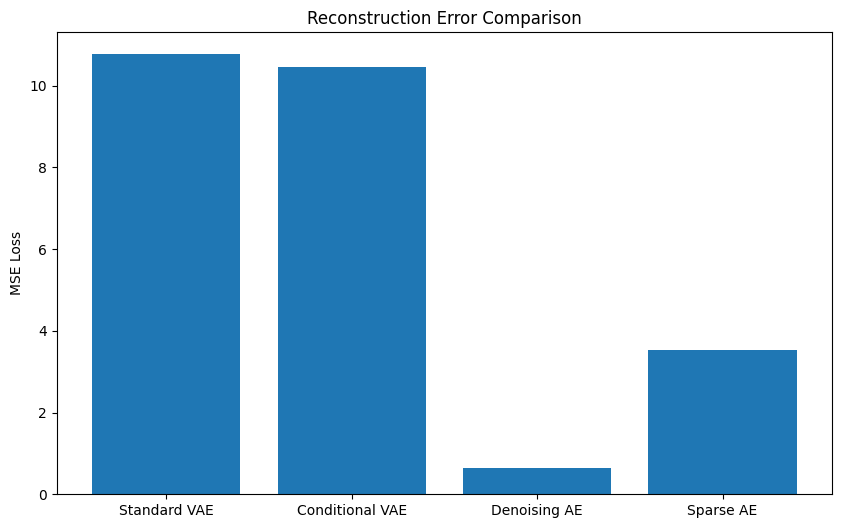

In [ ]:
# Evaluate model reconstruction quality for VAE, Conditional VAE, Denoising AE, or Sparse AE.(Reconstruction error (MSE))
def evaluate_reconstruction(model, test_loader, model_type='vae', is_conditional=False):
    model.eval()
    recon_error = 0
    with torch.no_grad():
        for data in test_loader:
            if isinstance(data, (list, tuple)):
                batch_X = data[0].to(device)
                props = data[1].to(device) if len(data) > 1 else None
            else:
                batch_X = data.to(device)
                props = None
            if model_type == 'cvae' or is_conditional:
                recon_batch, _, _ = model(batch_X, props)
            elif model_type == 'dae':
                output = model(batch_X)
                recon_batch = output if not isinstance(output, tuple) else output[0]
            elif model_type == 'sae':
                recon_batch, _ = model(batch_X)
            else:
                recon_batch, _, _ = model(batch_X)
            recon_error += F.mse_loss(recon_batch, batch_X, reduction='sum').item()
    avg_recon_error = recon_error / len(test_loader.dataset)
    return avg_recon_error

# Evaluate all models
std_recon_error = evaluate_reconstruction(std_vae, test_loader, model_type='vae')
cond_recon_error = evaluate_reconstruction(cond_vae, test_loader, model_type='cvae', is_conditional=True)
dae_recon_error = evaluate_reconstruction(dae, test_loader, model_type='dae')
sae_recon_error = evaluate_reconstruction(sparse_ae, test_loader, model_type='sae')

print(f"Standard VAE Reconstruction Error: {std_recon_error:.4f}")
print(f"Conditional VAE Reconstruction Error: {cond_recon_error:.4f}")
print(f"Denoising AE Reconstruction Error: {dae_recon_error:.4f}")
print(f"Sparse AE Reconstruction Error: {sae_recon_error:.4f}")

# Compare reconstruction errors
plt.figure(figsize=(10, 6))
plt.bar(['Standard VAE', 'Conditional VAE', 'Denoising AE', 'Sparse AE'],
        [std_recon_error, cond_recon_error, dae_recon_error, sae_recon_error])
plt.title('Reconstruction Error Comparison')
plt.ylabel('MSE Loss')
plt.show()

# Evaluating and Inferance of all models on a small sample of Molecules Smiles

In [ ]:
simple_molecules_df = df[df['smiles'].isin([
    "[H]C([H])([H])[H]",      # Methane (Mol 1)
    "[H]N([H])[H]",           # Ammonia (Mol 2)
    "[H]O[H]",                # Water (Mol 3)
    "[H]C#C[H]",              # Acetylene (Mol 4)
    "[H]C#N",                 # Hydrogen cyanide (Mol 5)
    "[H]C([H])=O",            # Formaldehyde (Mol 6)
    "[H]C([H])([H])C([H])([H])[H]",  # Ethane (Mol 7)
    "[H]OC([H])([H])[H]",     # Methanol (Mol 8)
    "[H]C#CC([H])([H])[H]",   # Propyne (Mol 9)
    "[H]C([H])([H])C#N"       # Acetonitrile (Mol 10)
])]

# # If you need to use canonical SMILES instead of the explicit hydrogen notation
from rdkit import Chem
canonical_smiles = [
    "C",        # Methane
    "N",        # Ammonia
    "O",        # Water
    "C#C",      # Acetylene
    "C#N",      # Hydrogen cyanide
    "C=O",      # Formaldehyde
    "CC",       # Ethane
    "CO",       # Methanol
    "C#CC",     # Propyne
    "CC#N"      # Acetonitrile
]

# Alternative approach using canonical SMILES
simple_molecules_df = df[df['smiles'].apply(lambda s: Chem.MolToSmiles(Chem.MolFromSmiles(s)) in canonical_smiles)]

In [ ]:
# Get the properties for these molecules
simple_props = simple_molecules_df[['homo','lumo','gap','molecular_weight','logp']].values
simple_props_tensor = torch.tensor(simple_props, dtype=torch.float32).to(device)

# Get or generate fingerprints for these molecules
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def get_fingerprints(smiles_list):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
            arr = np.zeros((2048,), dtype=np.float32)
            DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
    return fingerprints

# Get fingerprints
simple_fps = get_fingerprints(simple_molecules_df['smiles'].tolist())
simple_fps_tensor = torch.tensor(simple_fps, dtype=torch.float32).to(device)

Conditional VAE Reconstruction Error: 0.0011
Standard VAE Reconstruction Error: 0.0027
Sparse Autoencoder Reconstruction Error: 0.0006
Denoising Autoencoder Reconstruction Error: 0.0004


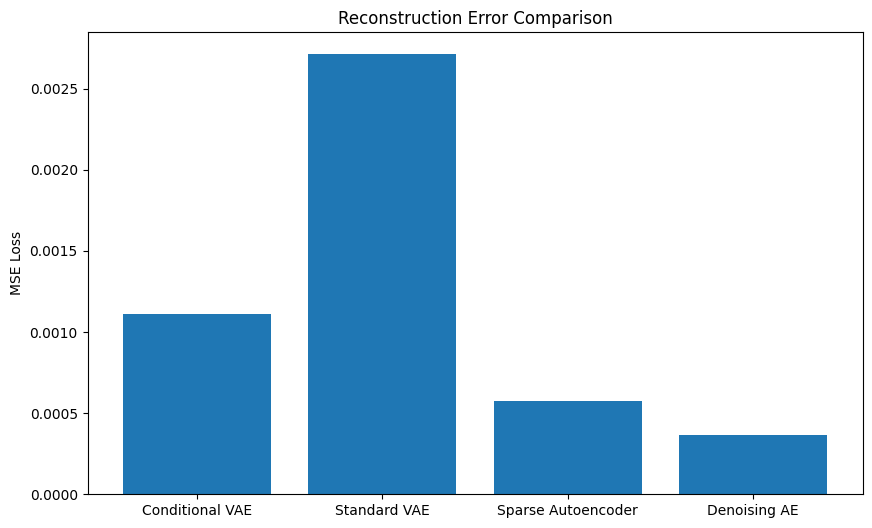

In [ ]:
def test_reconstruction(model, fps_tensor, props_tensor=None, model_name="Model"):
    model.eval()
    with torch.no_grad():
        # Forward pass
        if isinstance(model, ConditionalVAE) and props_tensor is not None:
            recon, mu, logvar = model(fps_tensor, props_tensor)
        elif isinstance(model, StandardVAE):
            recon, mu, logvar = model(fps_tensor)
        elif isinstance(model, DenoisingAutoencoder):
            recon, _, _ = model(fps_tensor)
        else:
            recon, _ = model(fps_tensor)

        # Calculate reconstruction error
        recon_error = F.mse_loss(recon, fps_tensor).item()

        # Convert to binary for visualization
        binary_orig = (fps_tensor > 0.5).float().cpu().numpy()
        binary_recon = (recon > 0.5).float().cpu().numpy()

        print(f"{model_name} Reconstruction Error: {recon_error:.4f}")

        return recon, recon_error


cond_recon, cond_error = test_reconstruction(cond_vae, simple_fps_tensor, simple_props_tensor, "Conditional VAE")
std_recon, std_error = test_reconstruction(std_vae, simple_fps_tensor, None, "Standard VAE")
sparse_recon, sparse_error = test_reconstruction(sparse_ae, simple_fps_tensor, None, "Sparse Autoencoder")
dae_recon, dae_error = test_reconstruction(dae, simple_fps_tensor, None, "Denoising Autoencoder")

models = ["Conditional VAE", "Standard VAE", "Sparse Autoencoder", "Denoising AE"]
recon_errors = [cond_error, std_error, sparse_error, dae_error]

plt.figure(figsize=(10, 6))
plt.bar(models, recon_errors)
plt.title('Reconstruction Error Comparison')
plt.ylabel('MSE Loss')
plt.show()

In [ ]:
#inference output extraction
cond_vae.eval()
std_vae.eval()
sparse_ae.eval()
dae.eval()

with torch.no_grad():
    # For Conditional VAE, input: fps + props
    cond_gen, _, _ = cond_vae(simple_fps_tensor, simple_props_tensor)
    # For Standard VAE, input: fps only
    std_gen, _, _ = std_vae(simple_fps_tensor)
    sparse_gen, _ = sparse_ae(simple_fps_tensor)
    # Denoising AE returns recon, z, pred_props
    dae_gen, _, _ = dae(simple_fps_tensor)

In [ ]:
def fingerprint_to_molecule(fp, reference_mols, reference_fps):
    """Find the most similar molecule from a reference set"""
    max_sim = -1
    nearest_mol = None
    nearest_idx = -1

    # Convert fp to RDKit format
    fp_bits = (fp > 0.5).astype(int)
    fp_str = ''.join(map(str, fp_bits))
    rdkit_fp = DataStructs.cDataStructs.CreateFromBitString(fp_str)

    for i, ref_fp in enumerate(reference_fps):
        # Convert reference fp to RDKit format
        ref_bits = (ref_fp > 0.5).astype(int)
        ref_str = ''.join(map(str, ref_bits))
        ref_rdkit_fp = DataStructs.cDataStructs.CreateFromBitString(ref_str)

        # Calculate similarity
        sim = DataStructs.TanimotoSimilarity(rdkit_fp, ref_rdkit_fp)
        if sim > max_sim:
            max_sim = sim
            nearest_idx = i

    if nearest_idx >= 0:
        nearest_mol = Chem.MolFromSmiles(reference_mols[nearest_idx])
        return nearest_mol, max_sim
    return None, 0.0

In [ ]:
from rdkit.Chem import QED, Descriptors
from rdkit.Chem.Lipinski import NumHDonors, NumHAcceptors, NumRotatableBonds
from rdkit.Chem.Descriptors import MolWt as MolecularWeight
def lipinski_violations(mol):
    """Calculate number of Lipinski rule violations."""
    violations = 0
    if MolecularWeight(mol) > 500:
        violations += 1
    if NumHDonors(mol) > 5:
        violations += 1
    if NumHAcceptors(mol) > 10:
        violations += 1
    if Descriptors.MolLogP(mol) > 5:
        violations += 1
    return violations

def compute_drug_likeness_scores(mols):
    """Compute drug-likeness scores for a list of RDKit molecules."""
    qed_scores = []
    lipinski_violations_counts = []
    for mol in mols:
        if mol:
            qed_scores.append(QED.qed(mol))
            lipinski_violations_counts.append(lipinski_violations(mol))
        else:
            qed_scores.append(None)
            lipinski_violations_counts.append(None)
    return qed_scores, lipinski_violations_counts

 **Lipinski’s Rule of Five** criteria a molecule violates. These rules predict oral drug-likeness based on:
- Molecular weight ≤ 500

- ≤ 5 hydrogen bond donors

- ≤ 10 hydrogen bond acceptors

- logP ≤ 5

**The QED score** (Quantitative Estimate of Drug-likeness) is a numerical measure of how "drug-like" a molecule is, based on a combination of multiple molecular properties.

In [ ]:
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from IPython.display import display

def visualize_generated_molecules_with_drug_scores(generated_fps, reference_smiles, reference_fps, model_name="Model"):
    mols = []
    similarities = []

    print(f"\n--- {model_name} Generated Molecules and Drug-Likeness Scores ---\n")

    for i, fp in enumerate(generated_fps[:10]):  # Just check first 10
        mol, sim = fingerprint_to_molecule(fp, reference_smiles, reference_fps)
        if mol:
            mols.append(mol)
            similarities.append(sim)

    # Compute drug-likeness scores for generated molecule
    qed_scores, lipinski_violations_counts = compute_drug_likeness_scores(mols)

    for i, (sim, qed, lip) in enumerate(zip(similarities, qed_scores, lipinski_violations_counts)):
        print(f"Molecule {i+1}: Similarity = {sim:.3f}, QED = {qed:.3f}, Lipinski Violations = {lip}")

    if mols:
        plt.figure(figsize=(12, 8))
        plt.suptitle(f"{model_name} - Generated Molecules", fontsize=16)
        legends = [f"QED: {qed:.2f} | LipV: {lip}" for qed, lip in zip(qed_scores, lipinski_violations_counts)]
        img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=legends)
        display(img)

    return mols, similarities, qed_scores, lipinski_violations_counts


# Generated Molecules by Standard VAE


--- Standard VAE Generated Molecules and Drug-Likeness Scores ---

Molecule 1: Similarity = 0.500, QED = 0.348, Lipinski Violations = 0
Molecule 2: Similarity = 0.091, QED = 0.370, Lipinski Violations = 0
Molecule 3: Similarity = 0.571, QED = 0.387, Lipinski Violations = 0
Molecule 4: Similarity = 0.000, QED = 0.360, Lipinski Violations = 0
Molecule 5: Similarity = 0.300, QED = 0.348, Lipinski Violations = 0
Molecule 6: Similarity = 0.500, QED = 0.387, Lipinski Violations = 0
Molecule 7: Similarity = 0.200, QED = 0.373, Lipinski Violations = 0
Molecule 8: Similarity = 0.400, QED = 0.385, Lipinski Violations = 0
Molecule 9: Similarity = 0.400, QED = 0.348, Lipinski Violations = 0
Molecule 10: Similarity = 0.500, QED = 0.387, Lipinski Violations = 0


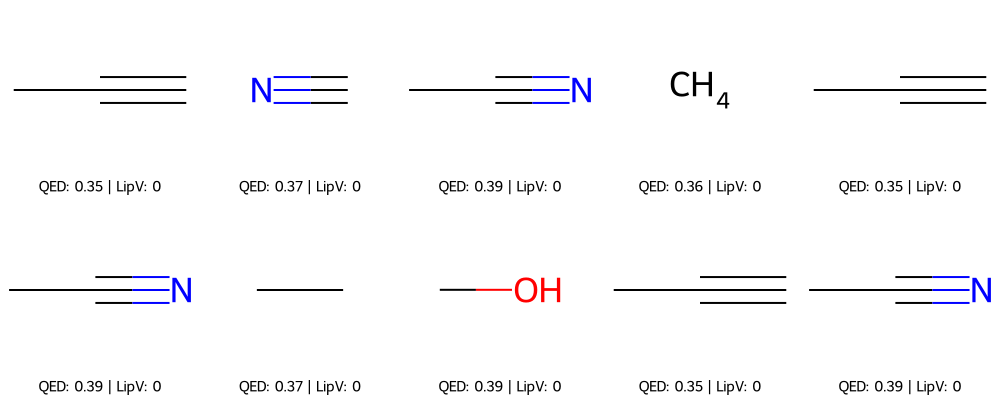

<Figure size 1200x800 with 0 Axes>

In [ ]:
std_mols, std_sims, std_qed, std_lip = visualize_generated_molecules_with_drug_scores(
    std_gen.cpu().numpy(),
    simple_molecules_df['smiles'].tolist(),
    simple_fps,
    model_name="Standard VAE")


# Generated Molecules by Conditional VAE


--- Conditional VAE Generated Molecules and Drug-Likeness Scores ---

Molecule 1: Similarity = 0.500, QED = 0.387, Lipinski Violations = 0
Molecule 2: Similarity = 0.000, QED = 0.360, Lipinski Violations = 0
Molecule 3: Similarity = 0.000, QED = 0.360, Lipinski Violations = 0
Molecule 4: Similarity = 0.000, QED = 0.360, Lipinski Violations = 0
Molecule 5: Similarity = 0.500, QED = 0.387, Lipinski Violations = 0
Molecule 6: Similarity = 0.000, QED = 0.360, Lipinski Violations = 0
Molecule 7: Similarity = 0.333, QED = 0.373, Lipinski Violations = 0
Molecule 8: Similarity = 0.667, QED = 0.385, Lipinski Violations = 0
Molecule 9: Similarity = 0.667, QED = 0.348, Lipinski Violations = 0
Molecule 10: Similarity = 0.667, QED = 0.387, Lipinski Violations = 0


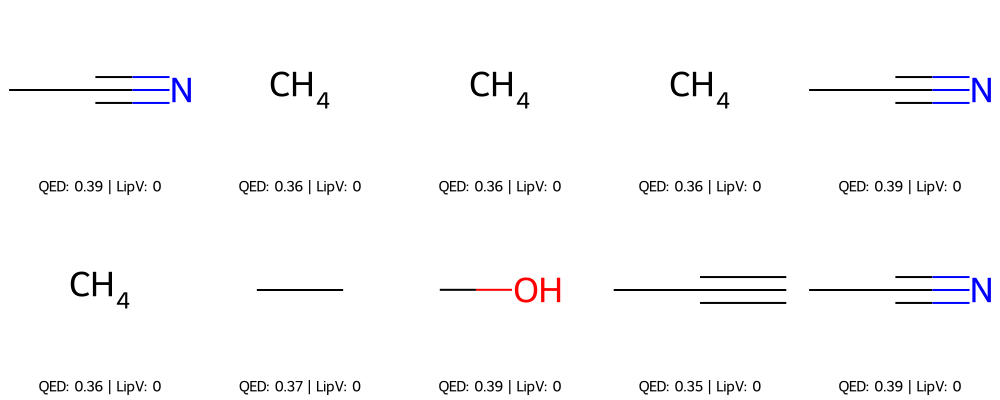

<Figure size 1200x800 with 0 Axes>

In [ ]:
cond_mols, cond_sims, cond_qed, cond_lip = visualize_generated_molecules_with_drug_scores(
    cond_gen.cpu().numpy(),
    simple_molecules_df['smiles'].tolist(),
    simple_fps,
    model_name="Conditional VAE")

# Generated Molecules by Sparse Autoencoder


--- Sparse Autoencoder Generated Molecules and Drug-Likeness Scores ---

Molecule 1: Similarity = 0.000, QED = 0.360, Lipinski Violations = 0
Molecule 2: Similarity = 0.000, QED = 0.360, Lipinski Violations = 0
Molecule 3: Similarity = 0.500, QED = 0.328, Lipinski Violations = 0
Molecule 4: Similarity = 0.500, QED = 0.333, Lipinski Violations = 0
Molecule 5: Similarity = 0.167, QED = 0.348, Lipinski Violations = 0
Molecule 6: Similarity = 0.333, QED = 0.361, Lipinski Violations = 0
Molecule 7: Similarity = 0.500, QED = 0.373, Lipinski Violations = 0
Molecule 8: Similarity = 0.667, QED = 0.385, Lipinski Violations = 0
Molecule 9: Similarity = 0.833, QED = 0.348, Lipinski Violations = 0
Molecule 10: Similarity = 0.667, QED = 0.387, Lipinski Violations = 0


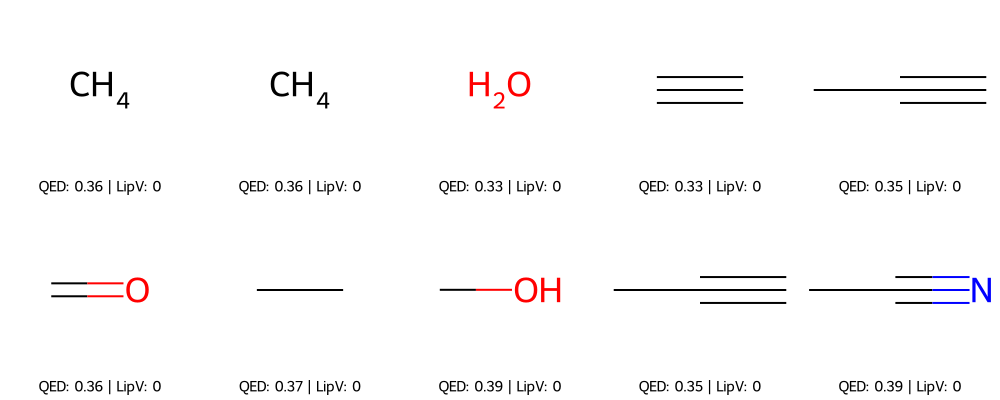

<Figure size 1200x800 with 0 Axes>

In [ ]:
sparse_mols, sparse_sims, sparse_qed, sparse_lip = visualize_generated_molecules_with_drug_scores(
    sparse_gen.cpu().numpy(),
    simple_molecules_df['smiles'].tolist(),
    simple_fps,
    model_name="Sparse Autoencoder")

# Generated Molecules By Denoising AE


--- Denoising AE Generated Molecules and Drug-Likeness Scores ---

Molecule 1: Similarity = 1.000, QED = 0.360, Lipinski Violations = 0
Molecule 2: Similarity = 1.000, QED = 0.398, Lipinski Violations = 0
Molecule 3: Similarity = 0.500, QED = 0.387, Lipinski Violations = 0
Molecule 4: Similarity = 0.500, QED = 0.333, Lipinski Violations = 0
Molecule 5: Similarity = 0.500, QED = 0.370, Lipinski Violations = 0
Molecule 6: Similarity = 1.000, QED = 0.361, Lipinski Violations = 0
Molecule 7: Similarity = 1.000, QED = 0.373, Lipinski Violations = 0
Molecule 8: Similarity = 1.000, QED = 0.385, Lipinski Violations = 0
Molecule 9: Similarity = 0.857, QED = 0.348, Lipinski Violations = 0
Molecule 10: Similarity = 0.857, QED = 0.387, Lipinski Violations = 0


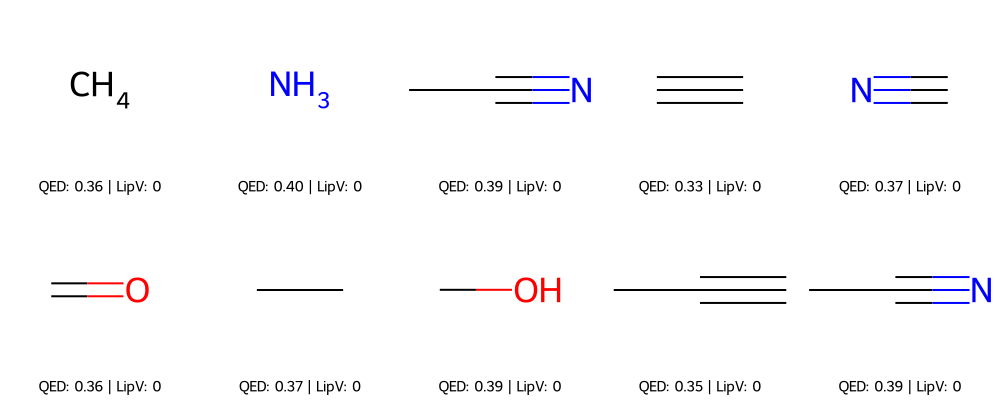

<Figure size 1200x800 with 0 Axes>

In [ ]:
dae_mols, dae_sims, dae_qed, dae_lip = visualize_generated_molecules_with_drug_scores(
    dae_gen.cpu().numpy(),
    simple_molecules_df['smiles'].tolist(),
    simple_fps,
    model_name="Denoising AE")


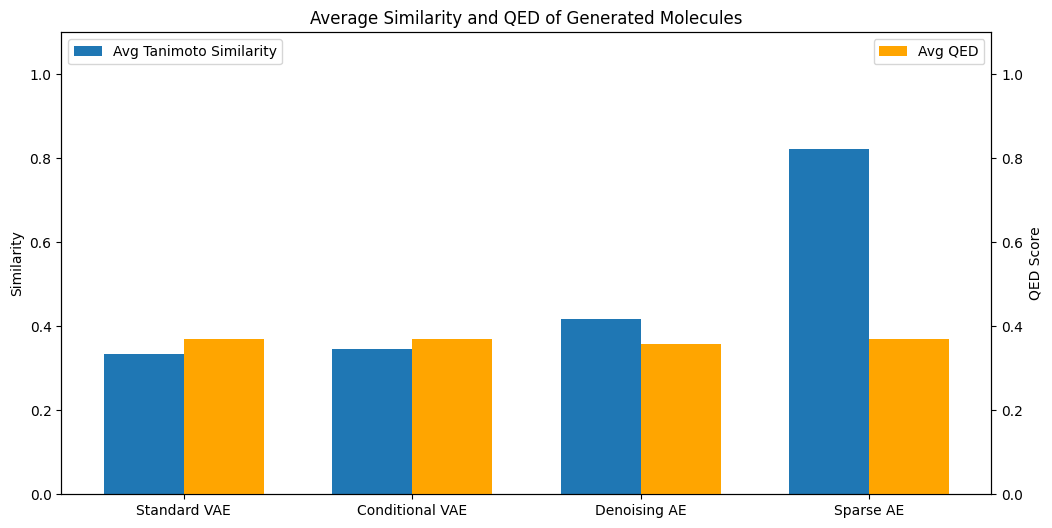

In [ ]:
# Plot average similarity and QED side-by-side
if len(cond_sims) > 0 and len(std_sims) > 0 and len(sparse_sims) > 0 and len(dae_sims) > 0:
    avg_sims = [np.mean(cond_sims), np.mean(std_sims), np.mean(sparse_sims), np.mean(dae_sims)]
    avg_qeds = [np.mean(cond_qed), np.mean(std_qed), np.mean(sparse_qed), np.mean(dae_qed)]

    x = np.arange(len(models))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.bar(x - width/2, avg_sims, width, label='Avg Tanimoto Similarity')
    ax1.set_ylabel('Similarity')
    ax1.set_ylim(0, 1.1)

    ax2 = ax1.twinx()
    ax2.bar(x + width/2, avg_qeds, width, color='orange', label='Avg QED')
    ax2.set_ylabel('QED Score')
    ax2.set_ylim(0, 1.1)

    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.set_title('Average Similarity and QED of Generated Molecules')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

# Comaprison between all metrics of all four models

                Model  Reconstruction Error  Validity Rate  Property Error  \
3        Denoising AE                0.0004         1.0000          0.4089   
2  Sparse Autoencoder                0.0006         1.0000          0.4803   
0     Conditional VAE                0.0011         1.0000          0.4812   
1        Standard VAE                0.0027         1.0000          0.6105   

   Diversity  Overall Score  
3     0.2718         1.0000  
2     0.1634         0.5188  
0     0.1843         0.5053  
1     0.1816         0.0560  


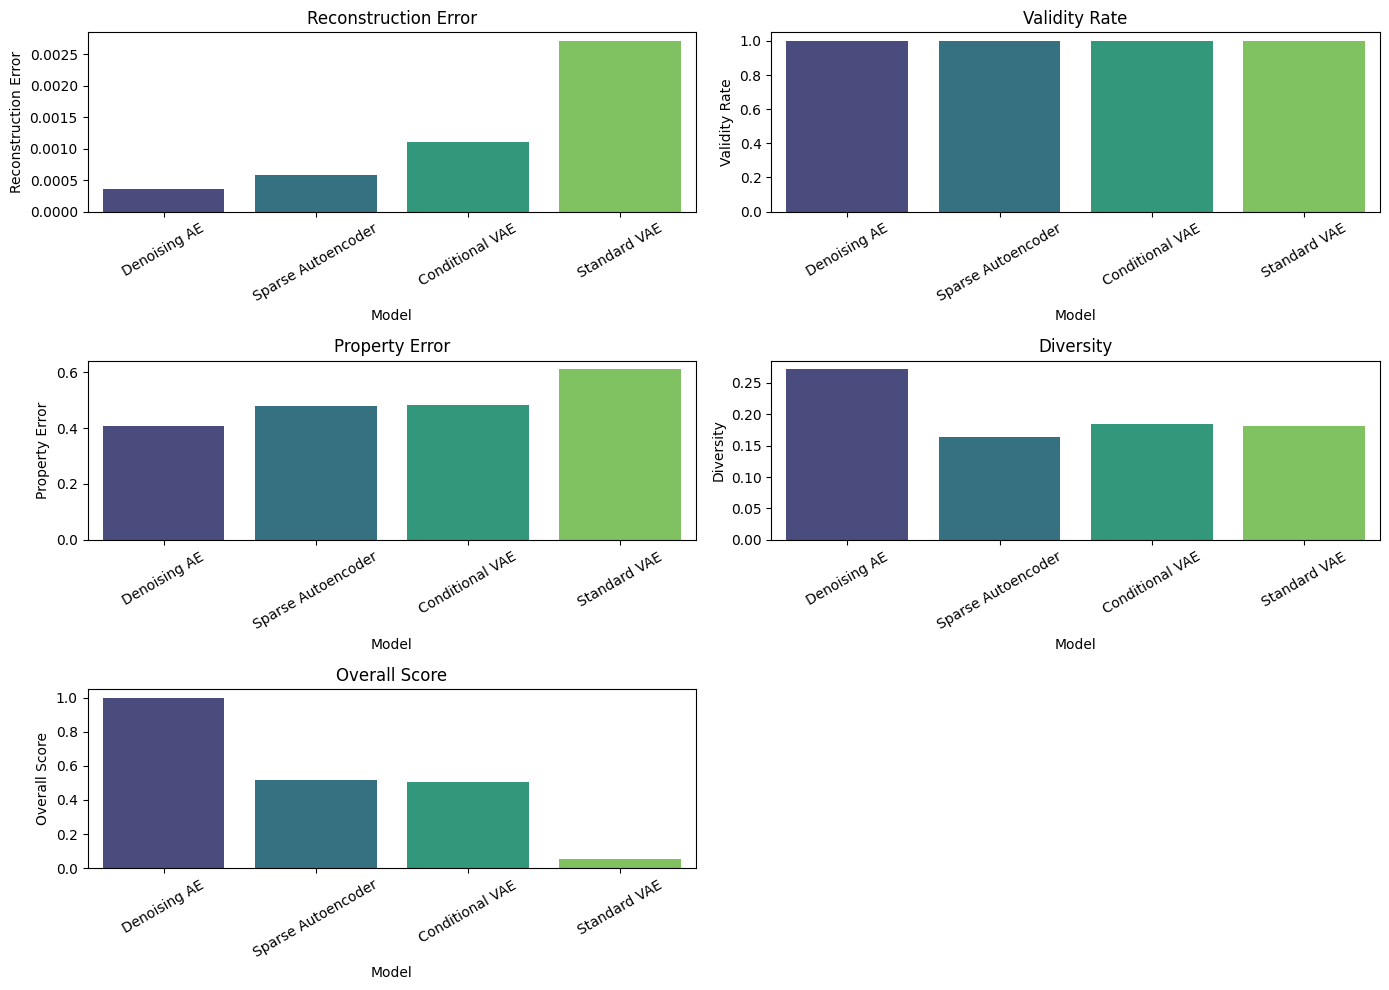

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.4f}'.format

# Create DataFrame for model metrics
model_comparison = pd.DataFrame({
    'Model': ['Conditional VAE', 'Standard VAE', 'Sparse Autoencoder', 'Denoising AE'],
    'Reconstruction Error': [cond_error, std_error, sparse_error, dae_error],
    'Validity Rate': [results['conditional_vae'].get('validity', np.nan),
                      results['standard_vae'].get('validity', np.nan),
                      results['sparse_ae'].get('validity', np.nan),
                      results['denoising_ae'].get('validity', np.nan)],
    'Property Error': [results['conditional_vae'].get('property_error', np.nan),
                       results['standard_vae'].get('property_error', np.nan),
                       results['sparse_ae'].get('property_error', np.nan),
                       results['denoising_ae'].get('property_error', np.nan)],
    'Diversity': [results['conditional_vae'].get('diversity', np.nan),
                  results['standard_vae'].get('diversity', np.nan),
                  results['sparse_ae'].get('diversity', np.nan),
                  results['denoising_ae'].get('diversity', np.nan)]
})

# Normalize metrics for ranking (min-max scaling, better is lower for Error, higher for Validity & Diversity)
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize each metric appropriately:
model_comparison['Recon_Error_Norm'] = 1 - min_max_scale(model_comparison['Reconstruction Error'])  # lower error better
model_comparison['Validity_Norm'] = min_max_scale(model_comparison['Validity Rate'])               # higher better
model_comparison['Property_Error_Norm'] = 1 - min_max_scale(model_comparison['Property Error'])    # lower better
model_comparison['Diversity_Norm'] = min_max_scale(model_comparison['Diversity'])                  # higher better

# Compute overall score
model_comparison['Overall Score'] = model_comparison[['Recon_Error_Norm', 'Validity_Norm',
                                                      'Property_Error_Norm', 'Diversity_Norm']].mean(axis=1)

model_comparison_sorted = model_comparison.sort_values('Overall Score', ascending=False)

print(model_comparison_sorted[['Model', 'Reconstruction Error', 'Validity Rate', 'Property Error', 'Diversity', 'Overall Score']])

# Plotting each metric
metrics = ['Reconstruction Error', 'Validity Rate', 'Property Error', 'Diversity', 'Overall Score']
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x='Model', y=metric, data=model_comparison_sorted, palette='viridis')
    plt.title(metric)
    plt.xticks(rotation=30)
    plt.tight_layout()

plt.show()


# Detailed Analysis Of Models Latent Space Using (PCA/t-SNE) Visualizations

In [ ]:
def extract_latents(model, test_loader, n_samples=1000):
    model.eval()
    latents, props = [], []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            if isinstance(model, ConditionalVAE):
                mu, _ = model.encode(batch_X, batch_y)
                latents.append(mu.cpu().numpy())
            elif isinstance(model, StandardVAE):
                mu, _ = model.encode(batch_X)
                latents.append(mu.cpu().numpy())
            elif isinstance(model, DenoisingAutoencoder):
                z, _, _ = model(batch_X)
                latents.append(z.cpu().numpy())
            else:  # Sparse AE
                z = model.encoder(batch_X)
                latents.append(z.cpu().numpy())

            props.append(batch_y.cpu().numpy())

            if len(latents) * batch_X.shape[0] >= n_samples:
                break

    return np.vstack(latents)[:n_samples], np.vstack(props)[:n_samples]



In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_latent_comparison(models_dict, test_loader, n_samples=1000):
    n_models = len(models_dict)
    fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 10))

    for i, (name, model) in enumerate(models_dict.items()):
        latents, props = extract_latents(model, test_loader, n_samples)

        pca = PCA(n_components=2).fit_transform(latents)
        tsne = TSNE(n_components=2, random_state=42).fit_transform(latents)

        # PCA
        scatter = axes[0, i].scatter(pca[:, 0], pca[:, 1], c=props[:, 0], cmap='viridis', alpha=0.7)
        axes[0, i].set_title(f'{name} - PCA')
        fig.colorbar(scatter, ax=axes[0, i], label='HOMO Energy')

        # t-SNE
        scatter = axes[1, i].scatter(tsne[:, 0], tsne[:, 1], c=props[:, 0], cmap='viridis', alpha=0.7)
        axes[1, i].set_title(f'{name} - t-SNE')
        fig.colorbar(scatter, ax=axes[1, i], label='HOMO Energy')

    plt.tight_layout()
    plt.show()


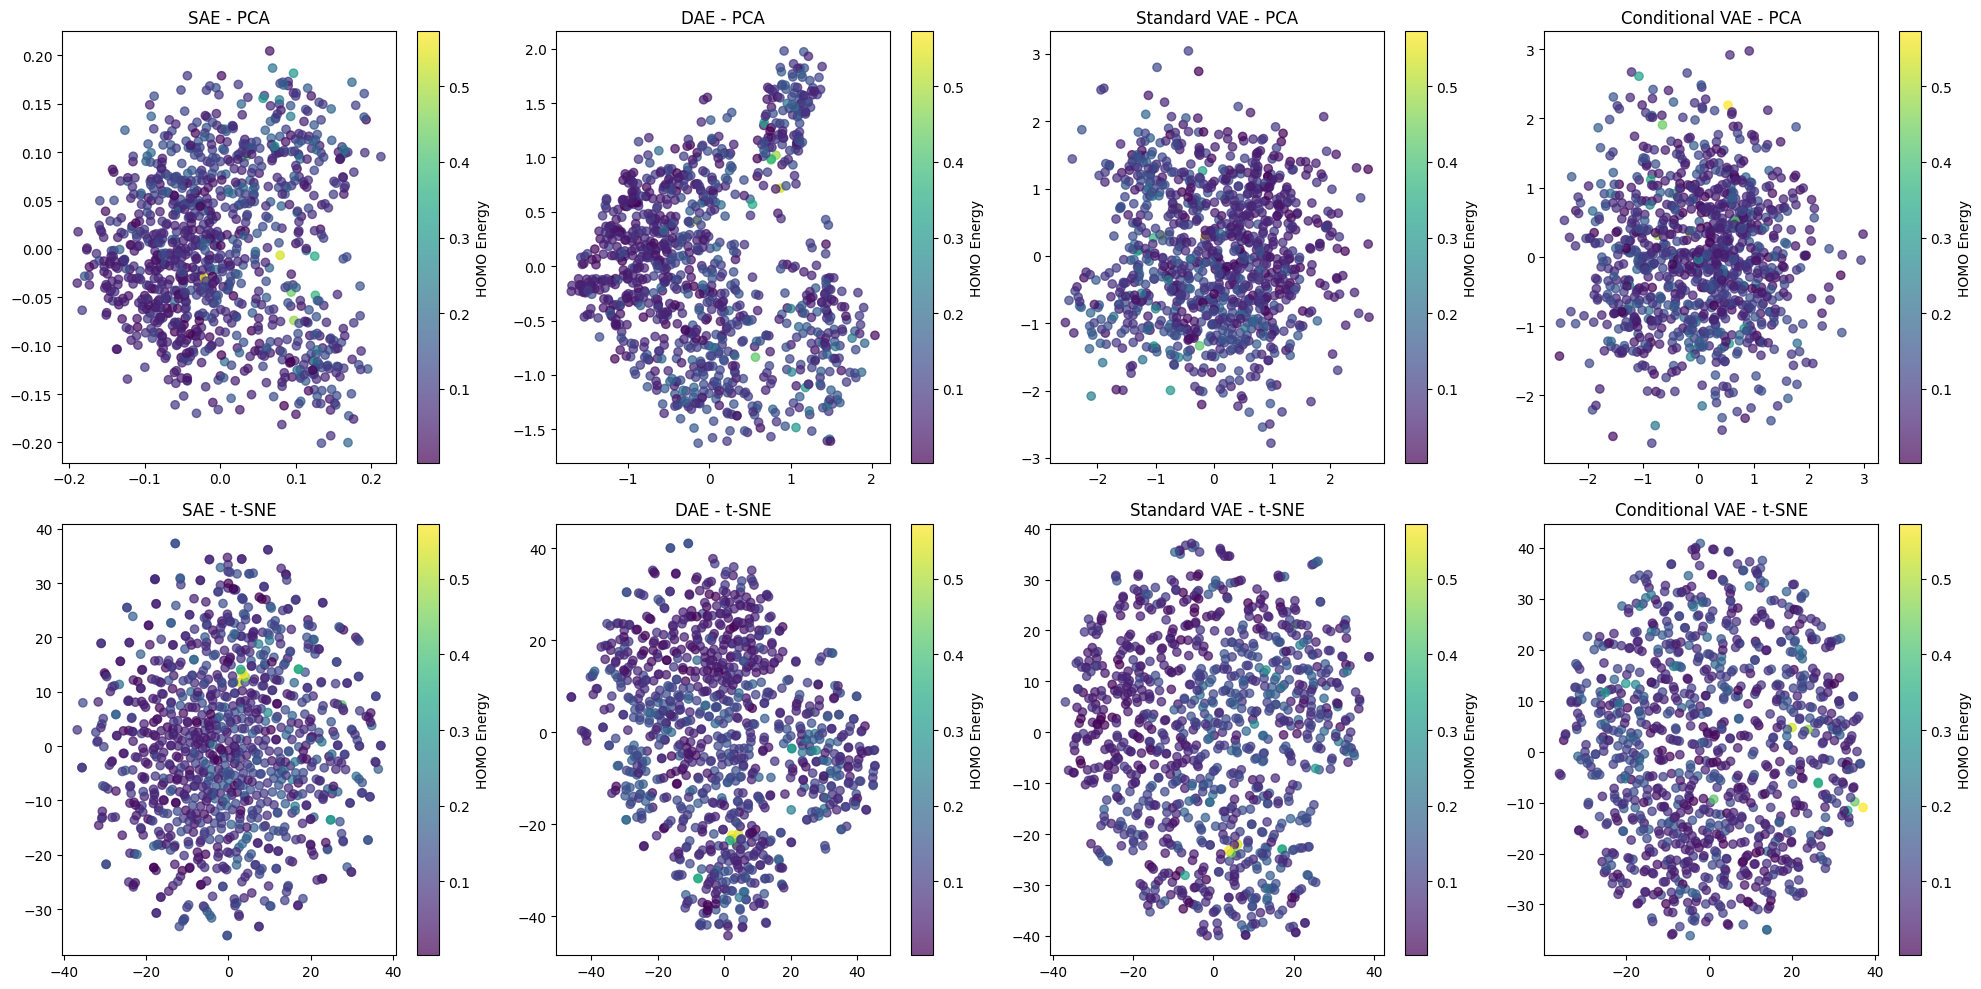

In [ ]:
models = {
    'SAE': sparse_ae,
    'DAE': dae,
    'Standard VAE': std_vae,
    'Conditional VAE': cond_vae
}

plot_latent_comparison(models, test_loader, n_samples=1000)


-  The DAE shows the most structured latent space in both PCA and t-SNE, suggesting it has learned meaningful molecular representations
- The Standard VAE shows the characteristic regularized distribution expected from the KL divergence term
- The Conditional VAE's latent space shows the influence of property conditioning
- The SAE has the most compact representation in PCA but expands in t-SNE

Property Correlation (color gradient):
- The color gradient (representing HOMO energy values) shows some correlation with spatial positioning, especially in the DAE
- This suggests the models have learned to encode this molecular property in their latent spaces

Dimensionality Reduction Comparison :

- t-SNE reveals more local structure and potential clusters not visible in PCA
- PCA better shows the global distribution and overall variance